In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --------------------------------------------------------
# Squeeze-and-Excitation Layer
# --------------------------------------------------------
class SELayer(nn.Module):
    def __init__(self, in_channels, reduction=4):
        super().__init__()
        hidden = in_channels // reduction
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),       # -> [B, C, 1, 1]
            nn.Conv2d(in_channels, hidden, 1),
            nn.SiLU(),
            nn.Conv2d(hidden, in_channels, 1),
            nn.Sigmoid())

    def forward(self, x):
        scale = self.fc(x)
        return x * scale

In [3]:
# --------------------------------------------------------
# MBConv Block
# --------------------------------------------------------
class MBConv(nn.Module):
    def __init__(self, in_ch, out_ch, expand_ratio, stride, kernel):
        super().__init__()

        hidden = in_ch * expand_ratio
        self.use_residual = (stride == 1 and in_ch == out_ch)

        layers = []

        # 1) Expansion (1x1 conv)
        if expand_ratio != 1:
            layers += [
                nn.Conv2d(in_ch, hidden, 1, bias=False),
                nn.BatchNorm2d(hidden),
                nn.SiLU()
            ]

        # 2) Depthwise conv
        layers += [
            nn.Conv2d(hidden, hidden, kernel, stride=stride,
                      padding=kernel//2, groups=hidden, bias=False),
            nn.BatchNorm2d(hidden),
            nn.SiLU()
        ]

        # 3) SE
        layers += [SELayer(hidden)]

        # 4) Projection (1x1 conv)
        layers += [
            nn.Conv2d(hidden, out_ch, 1, bias=False),
            nn.BatchNorm2d(out_ch),
        ]

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        out = self.block(x)
        if self.use_residual:
            return x + out
        return out


In [4]:

class EfficientNetB0(nn.Module):
    def __init__(self):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.SiLU()
        )

        config = [
            (1, 16, 1, 1, 3),
            (6, 24, 2, 2, 3),
            (6, 40, 2, 2, 5),
            (6, 80, 3, 2, 3),
            (6, 112, 3, 1, 5),
            (6, 192, 4, 2, 5),
            (6, 320, 1, 1, 3),
        ]

        layers = []
        in_channels = 32

        for expand, out_channels, repeats, stride, kernel in config:
            for i in range(repeats):
                s = stride if i == 0 else 1
                layers.append(MBConv(in_channels, out_channels, expand, s, kernel))
                in_channels = out_channels

        self.blocks = nn.Sequential(*layers)

        self.head = nn.Sequential(
            nn.Conv2d(320, 1280, 1),
            nn.BatchNorm2d(1280),
            nn.SiLU()
        )

        self.classifier = nn.Linear(1280, 1000)

    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        x = self.head(x)
        x = F.adaptive_avg_pool2d(x, 1)
        x = torch.flatten(x, 1)
        return self.classifier(x)

In [1]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader


transform = transforms.Compose([transforms.Resize(size=(224,224)),
                                transforms.ToTensor()])

data_train = datasets.ImageFolder("/Users/benjaminbrooke/.cache/kagglehub/datasets/sriramr/apples-bananas-oranges/versions/1/original_data_set/train_data", transform = transform)


train_loder = DataLoader(data_train,batch_size=20,shuffle=True)

In [5]:
model_efficient_net = EfficientNetB0()

In [6]:
optimizer = torch.optim.Adam(model_efficient_net.parameters(),lr = 0.01)

In [7]:
loss_fn = nn.CrossEntropyLoss()

In [10]:
from tqdm.notebook import tqdm

epoch = 1

loss_list = []
acc_list = []

for epoch in tqdm(range(epoch)):

    for X_batch, y_batch in tqdm(train_loder):

        optimizer.zero_grad()

        y_pred = model_efficient_net(X_batch)

        loss = loss_fn(y_pred,y_batch)

        loss.backward()

        optimizer.step()

        preds = y_pred.argmax(dim=1)

        acc = (preds == y_batch).float().mean().item()

        acc_list.append(acc)
        loss_list.append(loss.item())

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

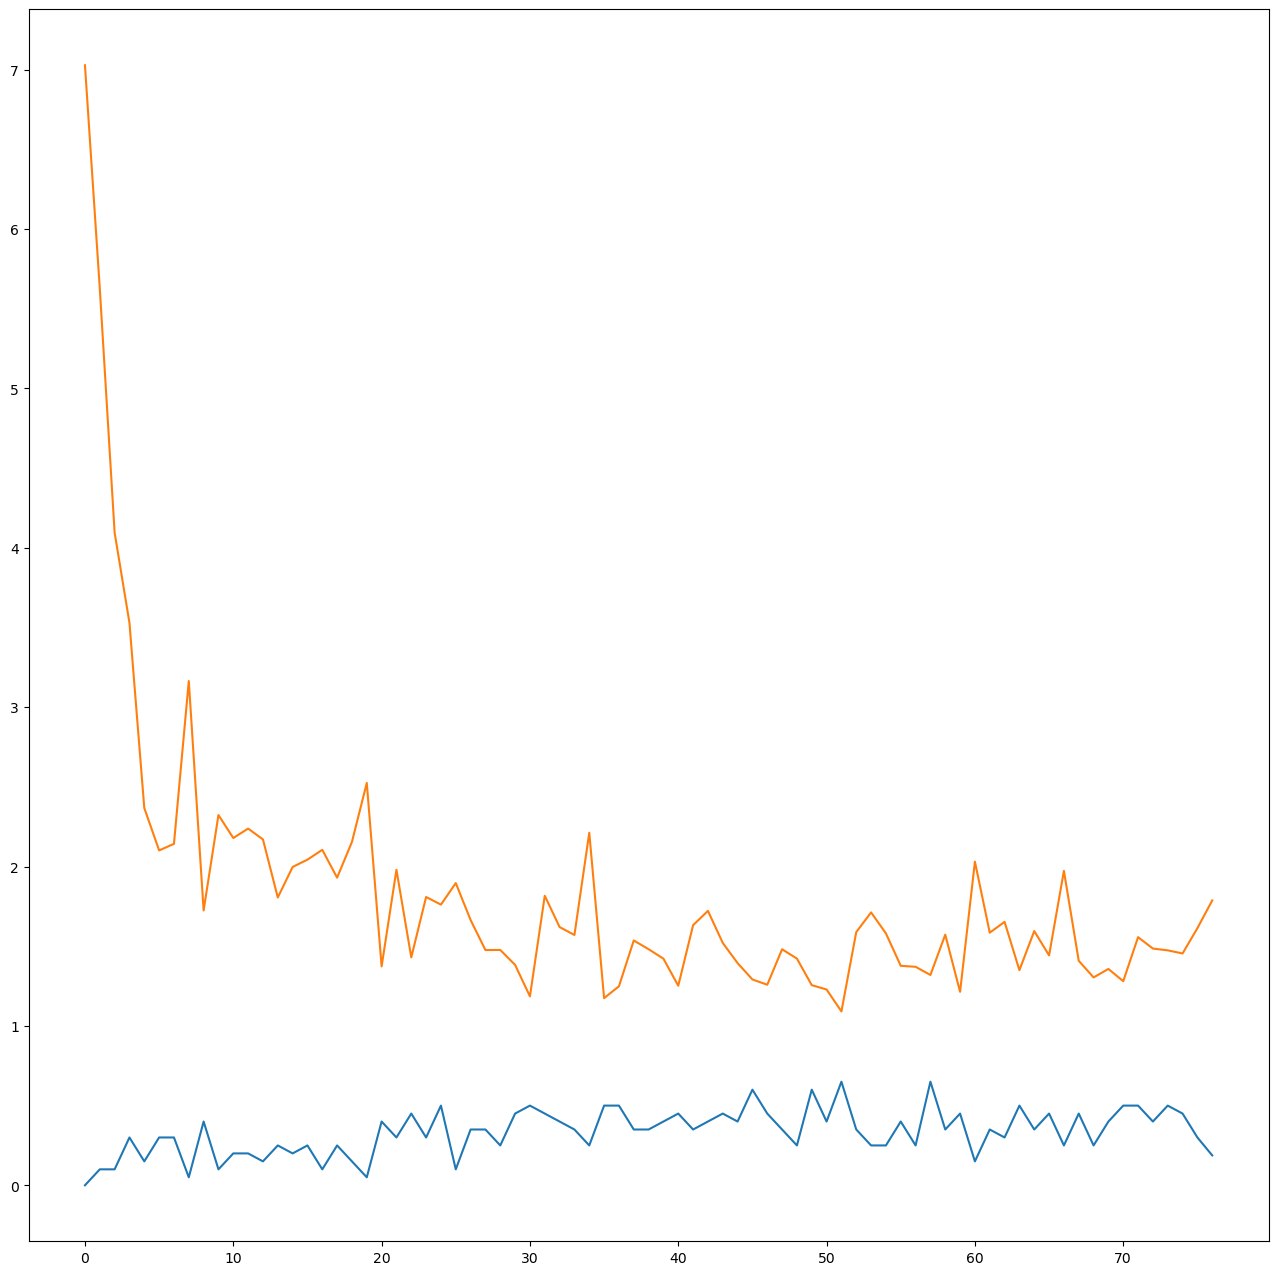

In [11]:
import matplotlib.pyplot as plt

x = range(len(loss_list))

plt.figure(figsize=(16,16))

plt.plot(x,acc_list)
plt.plot(x,loss_list)